In [1]:
# import bw2io as bi

In [2]:
# bi.restore_project_directory('/Users/timodiepers/Documents/Coding/brightway2-project-bw25_premise_background_v2-backup.26-March-2024-01-40PM.tar.gz', overwrite_existing=True, project_name='bw25_premise')

In [3]:
import bw2data as bd

In [4]:
bd.projects.set_current('bw25_premise')

In [5]:
bd.databases

Databases dictionary with 6 object(s):
	biosphere3
	cutoff39
	db_2020
	db_2030
	db_2040
	foreground

In [6]:
db_2020 = bd.Database("db_2020")
db_2030 = bd.Database("db_2030")
db_2040 = bd.Database("db_2040")

In [7]:
del bd.databases['foreground']

In [8]:
ev_background = [x for x in db_2020 if (x['name'] == 'transport, passenger car, electric')][0]
ev_background

'transport, passenger car, electric' (kilometer, GLO, None)

In [9]:
[e for e in ev_background.exchanges()]

In [10]:
car_prod_background = [x for x in db_2020 if (x['name'] == 'passenger car production, electric, without battery')][0]

In [11]:
[e for e in car_prod_background.exchanges()]

In [12]:
foreground = bd.Database("foreground")
foreground.write({})

In [13]:
#copy transport dataset
ev = ev_background.copy(name="copy of transport, passenger car, electric")
ev['database'] = 'foreground'
ev.save()

Successfully switch activity dataset to database `foreground`


In [14]:
# copy production dataset
car_prod = car_prod_background.copy(name="copy of passenger car production, electric, without battery")
car_prod['database'] = 'foreground'
car_prod.save()

Successfully switch activity dataset to database `foreground`


In [15]:
[e for e in ev.exchanges()]

[Exchange: 1.0 kilometer 'copy of transport, passenger car, electric' (kilometer, GLO, None) to 'copy of transport, passenger car, electric' (kilometer, GLO, None)>,
 Exchange: -1.050395781021507e-06 kilogram 'market for brake wear emissions, passenger car' (kilogram, GLO, None) to 'copy of transport, passenger car, electric' (kilometer, GLO, None)>,
 Exchange: -1.155435347754974e-05 kilogram 'market for road wear emissions, passenger car' (kilogram, GLO, None) to 'copy of transport, passenger car, electric' (kilometer, GLO, None)>,
 Exchange: -0.0026199999265372753 kilogram 'market for used Li-ion battery' (kilogram, GLO, None) to 'copy of transport, passenger car, electric' (kilometer, GLO, None)>,
 Exchange: -6.756759830750525e-05 kilogram 'market for tyre wear emissions, passenger car' (kilogram, GLO, None) to 'copy of transport, passenger car, electric' (kilometer, GLO, None)>,
 Exchange: 0.00048747999244369566 meter-year 'market for road' (meter-year, GLO, None) to 'copy of trans

In [16]:
# relink production dataset in transport dataset

old_car_prod = [x for x in ev.exchanges() if x.input['name'] == 'market for passenger car, electric, without battery'][0]
prod_amount = old_car_prod['amount']

old_car_prod.delete()

ev.new_edge(                 
    input=car_prod.key,
    amount=prod_amount,
    type="technosphere"
).save()


In [17]:
[e for e in ev.exchanges()]

[Exchange: 1.0 kilometer 'copy of transport, passenger car, electric' (kilometer, GLO, None) to 'copy of transport, passenger car, electric' (kilometer, GLO, None)>,
 Exchange: -1.050395781021507e-06 kilogram 'market for brake wear emissions, passenger car' (kilogram, GLO, None) to 'copy of transport, passenger car, electric' (kilometer, GLO, None)>,
 Exchange: -1.155435347754974e-05 kilogram 'market for road wear emissions, passenger car' (kilogram, GLO, None) to 'copy of transport, passenger car, electric' (kilometer, GLO, None)>,
 Exchange: -0.0026199999265372753 kilogram 'market for used Li-ion battery' (kilogram, GLO, None) to 'copy of transport, passenger car, electric' (kilometer, GLO, None)>,
 Exchange: -6.756759830750525e-05 kilogram 'market for tyre wear emissions, passenger car' (kilogram, GLO, None) to 'copy of transport, passenger car, electric' (kilometer, GLO, None)>,
 Exchange: 0.00048747999244369566 meter-year 'market for road' (meter-year, GLO, None) to 'copy of trans

In [18]:
from bw_temporalis import TemporalDistribution
import numpy as np

# defining Temporal Distributions of system
td_production = TemporalDistribution(
            date=np.array([-1], dtype='timedelta64[Y]'), #2023
            amount=np.array([1]))

td_use_phase = TemporalDistribution( #to be further refined based on use pattern
                    date=np.array([1, 6, 11, 16], dtype='timedelta64[Y]'), #2025, 2030, 2035, 2040
                    amount=np.array([0.25, 0.25, 0.25, 0.25]))

td_eol = TemporalDistribution(
            date=np.array([21], dtype='timedelta64[Y]'), #2045
            amount=np.array([1]))

td_eol_from_production_time = TemporalDistribution(
            date=np.array([22], dtype='timedelta64[Y]'), #2045, counting from 2023
            amount=np.array([1]))

In [19]:
#add TD to ev process
for exc in ev.exchanges():
    if "market for battery, Li-ion"in exc.input["name"]: #battery production
        exc["temporal_distribution"]= td_production
        exc.save()
        print("added TD to ", {exc.input["name"]})

    elif "copy of passenger car production, electric, without battery"in exc.input["name"]: # foreground car production
        exc["temporal_distribution"]= td_production
        exc.save()
        print("added TD to ", {exc.input["name"]})

    elif "market group for electricity, low voltage" in exc.input["name"]: #electricity while driving
        exc["temporal_distribution"]= td_use_phase
        exc.save()
        print("added TD to ", {exc.input["name"]})

    elif "market for used Li-ion battery" in exc.input["name"]:   #battery recycling
        exc["temporal_distribution"]= td_eol
        exc.save()
        print("added TD to ", {exc.input["name"]})

    elif "wear emissions, passenger car" in exc.input["name"]: #brake, road and tyre wear while driving
        exc["temporal_distribution"]= td_use_phase
        exc.save()
        print("added TD to ", {exc.input["name"]})
    
    elif "market for maintenance, passenger car" in exc.input["name"]: #car maintenance while driving
        exc["temporal_distribution"]= td_use_phase
        exc.save()
        print("added TD to ", {exc.input["name"]})
            
    elif exc.input["name"] == "market for road": # road usage while driving
        exc["temporal_distribution"]= td_use_phase
        exc.save()
        print("added TD to ", {exc.input["name"]})
    
    elif exc.input["name"] == exc.output["name"]: #skip production exchange
        continue

    else:
        print("no TD added to ", {exc.input["name"]})

    # car recycling is modelled at the level of car production, and TD is added there

added TD to  {'market for brake wear emissions, passenger car'}
added TD to  {'market for road wear emissions, passenger car'}
added TD to  {'market for used Li-ion battery'}
added TD to  {'market for tyre wear emissions, passenger car'}
added TD to  {'market for road'}
added TD to  {'market for battery, Li-ion, LiMn2O4, rechargeable, prismatic'}
added TD to  {'market for maintenance, passenger car, electric, without battery'}
added TD to  {'market group for electricity, low voltage'}
added TD to  {'copy of passenger car production, electric, without battery'}


In [20]:
for exc in car_prod.exchanges():
    if "waste" in exc.input["name"]: # all waste are EoL processes
        exc["temporal_distribution"]= td_eol_from_production_time 
        exc.save()
        print("added TD to ", {exc.input["name"]})

    elif "manual dismantling" in exc.input["name"]: # all waste are EoL processes
        exc["temporal_distribution"]= td_eol_from_production_time
        exc.save()
        print("added TD to ", {exc.input["name"]})
    
    elif exc.input["name"] == exc.output["name"]: #skip production exchange
        continue

    else:
        print("no TD added to ", {exc.input["name"]})
        # production processes (glider and powertrain) are already temporalized at the level of the transport process

added TD to  {'market for waste glass'}


added TD to  {'market for waste rubber, unspecified'}
added TD to  {'market for waste glass'}
added TD to  {'market group for waste glass'}
added TD to  {'market for waste mineral oil'}
added TD to  {'market for waste rubber, unspecified'}
added TD to  {'market for waste glass'}
added TD to  {'market for waste mineral oil'}
added TD to  {'market for waste mineral oil'}
added TD to  {'market for waste rubber, unspecified'}
added TD to  {'market for waste glass'}
added TD to  {'market for waste glass'}
added TD to  {'market for waste glass'}
added TD to  {'market for waste glass'}
no TD added to  {'market for glider, passenger car'}
no TD added to  {'market for powertrain, for electric passenger car'}
added TD to  {'market for manual dismantling of used electric passenger car'}


In [21]:
method = ('IPCC 2021 no LT',
 'climate change no LT',
 'global warming potential (GWP100) no LT')

In [22]:
from datetime import datetime

database_date_dict = {
    "db_2020": datetime.strptime("2020", "%Y"),
    "db_2030": datetime.strptime("2030", "%Y"),
    "db_2040": datetime.strptime("2040", "%Y"),
    # "cutoff39": datetime.strptime("2020", "%Y"), # all databases need to have a corresponding time
    "foreground": "dynamic",  # flag databases that should be temporally distributed with "dynamic"
}

In [23]:
from timex_lca import TimexLCA
tlca = TimexLCA({ev.key: 1}, method, None, database_date_dict, cutoff= 0.0000001) 


Starting graph traversal
Calculation count: 8


In [24]:
tlca.build_timeline()

c:\users\mullera\onedrive - vito\documents\04_coding\tictac_lca\timex_lca\timeline_builder.py:327: Warning: Reference date 2045-01-01 00:00:00 is higher than all provided dates. Data will be taken from the closest lower year.
  warnings.warn(


,hash_producer,time_mapped_producer,date_producer,producer,producer_name,hash_consumer,time_mapped_consumer,date_consumer,consumer,consumer_name,amount,interpolation_weights
0,2023,98282,2023-01-01,27559,"market for glider, passenger car",2023,98285,2023-01-01,98281,"copy of passenger car production, electric, wi...",0.912635,"{'db_2020': 0.6999726252395291, 'db_2030': 0.3..."
1,2023,98283,2023-01-01,46481,"market for powertrain, for electric passenger car",2023,98285,2023-01-01,98281,"copy of passenger car production, electric, wi...",0.087365,"{'db_2020': 0.6999726252395291, 'db_2030': 0.3..."
2,2023,98284,2023-01-01,35045,"market for battery, Li-ion, LiMn2O4, rechargea...",2024,98286,2024-01-01,98280,"copy of transport, passenger car, electric",0.00262,"{'db_2020': 0.6999726252395291, 'db_2030': 0.3..."
3,2023,98285,2023-01-01,98281,"copy of passenger car production, electric, wi...",2024,98286,2024-01-01,98280,"copy of transport, passenger car, electric",0.006121,"{'db_2020': 0.6999726252395291, 'db_2030': 0.3..."
4,2024,98286,2024-01-01,98280,"copy of transport, passenger car, electric",2024,-1,2024-01-01,-1,-1,1.0,"{'db_2020': 0.6000547495209416, 'db_2030': 0.3..."
5,2025,98287,2025-01-01,31847,market for road,2024,98286,2024-01-01,98280,"copy of transport, passenger car, electric",0.000122,"{'db_2020': 0.4998631261976457, 'db_2030': 0.5..."
6,2025,98288,2025-01-01,40481,"market for maintenance, passenger car, electri...",2024,98286,2024-01-01,98280,"copy of transport, passenger car, electric",0.000002,"{'db_2020': 0.4998631261976457, 'db_2030': 0.5..."
7,2025,98289,2025-01-01,50069,"market group for electricity, low voltage",2024,98286,2024-01-01,98280,"copy of transport, passenger car, electric",0.04975,"{'db_2020': 0.4998631261976457, 'db_2030': 0.5..."
8,2030,98290,2030-01-01,31847,market for road,2024,98286,2024-01-01,98280,"copy of transport, passenger car, electric",0.000122,{'db_2030': 1}
9,2030,98291,2030-01-01,40481,"market for maintenance, passenger car, electri...",2024,98286,2024-01-01,98280,"copy of transport, passenger car, electric",0.000002,{'db_2030': 1}


In [25]:
tlca.build_datapackage()
tlca.lci()
tlca.lcia()

In [26]:
co2_flows = [flow for flow in bd.Database('biosphere3') if 'Carbon dioxide' in flow['name'] and "air" in flow['categories']]
co2_flows

['Carbon dioxide, non-fossil' (kilogram, None, ('air', 'non-urban air or from high stacks')),
 'Carbon dioxide, from soil or biomass stock' (kilogram, None, ('air', 'non-urban air or from high stacks')),
 'Carbon dioxide, fossil' (kilogram, None, ('air',)),
 'Carbon dioxide, non-fossil' (kilogram, None, ('air', 'lower stratosphere + upper troposphere')),
 'Carbon dioxide, fossil' (kilogram, None, ('air', 'non-urban air or from high stacks')),
 'Carbon dioxide, from soil or biomass stock' (kilogram, None, ('air', 'lower stratosphere + upper troposphere')),
 'Carbon dioxide, non-fossil' (kilogram, None, ('air', 'urban air close to ground')),
 'Carbon dioxide, non-fossil' (kilogram, None, ('air', 'low population density, long-term')),
 'Carbon dioxide, fossil' (kilogram, None, ('air', 'lower stratosphere + upper troposphere')),
 'Carbon dioxide, fossil' (kilogram, None, ('air', 'low population density, long-term')),
 'Carbon dioxide, non-fossil' (kilogram, None, ('air',)),
 'Carbon dioxid

In [27]:
co2_flows_codes = [flow.key[1] for flow in co2_flows]

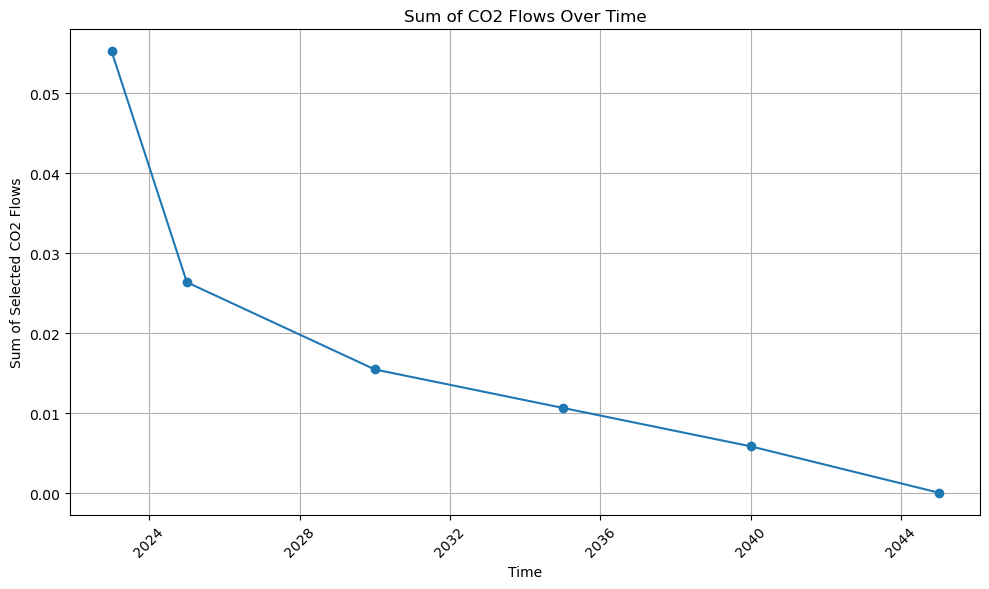

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Initialize a defaultdict to store summed amounts for each unique time point
time_amounts = defaultdict(float)

# Iterate over each specified flow and aggregate amounts by time
for flow_id in co2_flows_codes:
    if flow_id in tlca.dynamic_inventory:
        flow_data = tlca.dynamic_inventory[flow_id]
        for time, amount in zip(flow_data['time'], flow_data['amount']):
            time_amounts[str(time)] += amount  # Convert time to string for uniqueness

# Sort the times and amounts for plotting
sorted_times = np.array(sorted(time_amounts.keys()))
sorted_amounts = np.array([time_amounts[time] for time in sorted_times])

# Convert sorted times from strings back to datetime for plotting
sorted_times = np.array(sorted_times, dtype='datetime64')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(sorted_times, sorted_amounts, marker='o', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Sum of Selected CO2 Flows')
plt.title('Sum of CO2 Flows Over Time')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate dates for better readability
plt.tight_layout()  # Adjust layout to make room for the rotated date labels
plt.show()